In [55]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = pd.read_csv("./data/Elspotprices.csv", sep=";")
df.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2024-04-13 21:00,2024-04-13 23:00,DK1,"52,590000","7,050000"
1,2024-04-13 20:00,2024-04-13 22:00,DK1,"153,679993","20,600000"
2,2024-04-13 19:00,2024-04-13 21:00,DK1,"258,500000","34,650002"
3,2024-04-13 18:00,2024-04-13 20:00,DK1,"298,630005","40,029999"
4,2024-04-13 17:00,2024-04-13 19:00,DK1,"373,760010","50,099998"


In [56]:
TRAIN_DAYS= 200

df = df[['HourDK', 'SpotPriceEUR' ]]
df['HourDK'] = pd.to_datetime(df['HourDK'])
df = df[(df['HourDK'] >= '2023-01-01') & (df['HourDK'] <= '2023-12-31')]
df = df.iloc[::-1]
df['item_id'] = 'electricity_price'
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',', '.').astype(float)
df_test = df.copy()
df = df.iloc[:TRAIN_DAYS*24 - 1]
df_test = df_test.iloc[(TRAIN_DAYS*24) -1:(TRAIN_DAYS+1)*24 -1]
df_test.head()


,HourDK,SpotPriceEUR,item_id
6455,2023-07-20 00:00:00,98.129997,electricity_price
6454,2023-07-20 01:00:00,94.349998,electricity_price
6453,2023-07-20 02:00:00,82.900002,electricity_price
6452,2023-07-20 03:00:00,80.230003,electricity_price
6451,2023-07-20 04:00:00,71.099998,electricity_price


In [61]:

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="HourDK",
)
test_data = TimeSeriesDataFrame.from_data_frame(
    df_test,
    id_column="item_id",
    timestamp_column="HourDK",
)

test_data.head()

SpotPriceEUR
item_id           timestamp                        
electricity_price 2023-07-20 00:00:00     98.129997
                  2023-07-20 01:00:00     94.349998
                  2023-07-20 02:00:00     82.900002
                  2023-07-20 03:00:00     80.230003
                  2023-07-20 04:00:00     71.099998

In [29]:
predictor = TimeSeriesPredictor(
    prediction_length=24,
    path="autogluon-m4-hourly",
    target="SpotPriceEUR",
    eval_metric="MASE",
    freq="H",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

c:\energy_price_forecasting\Lib\site-packages\autogluon\timeseries\predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\energy_price_forecasting\autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       3.54 GB / 15.73 GB (22.5%)
Disk Space Avail:   267.38 GB / 456.62 GB (58.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3

In [63]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean        0.1        0.2  \
item_id           timestamp                                              
electricity_price 2023-07-20 00:00:00  96.736041  73.492583  80.952352   
                  2023-07-20 01:00:00  90.122555  58.483924  69.434028   
                  2023-07-20 02:00:00  85.811871  46.281738  60.153815   
                  2023-07-20 03:00:00  79.706375  41.361053  53.015988   
                  2023-07-20 04:00:00  81.816305  36.186452  50.893392   

                                             0.3        0.4        0.5  \
item_id           timestamp                                              
electricity_price 2023-07-20 00:00:00  86.175913  91.921061  96.736041   
                  2023-07-20 01:00:00  77.184729  83.953470  90.122555   
                  2023-07-20 02:00:00  68.876375  78.409625  85.811871   
                  2023-07-20 03:00:00  64.804370  72.488392  79.706375   
                  2023-07-20 04:00:00  63.246500  72.792046  81.816305   

                                              0.6         0.7         0.8  \
item_id           timestamp                                                 
electricity_price 2023-07-20 00:00:00  101.749231  106.599499  112.081446   
                  2023-07-20 01:00:00   95.779393  102.990356  111.482710   
                  2023-07-20 02:00:00   94.596648  102.662892  112.628844   
                  2023-07-20 03:00:00   89.726512  100.639239  110.595513   
                  2023-07-20 04:00:00   91.776045  103.236497  113.757870   

                                              0.9  
item_id           timestamp                        
electricity_price 2023-07-20 00:00:00  121.070309  
                  2023-07-20 01:00:00  123.364111  
                  2023-07-20 02:00:00  126.096556  
                  2023-07-20 03:00:00  124.330596  
                  2023-07-20 04:00:00  132.843717

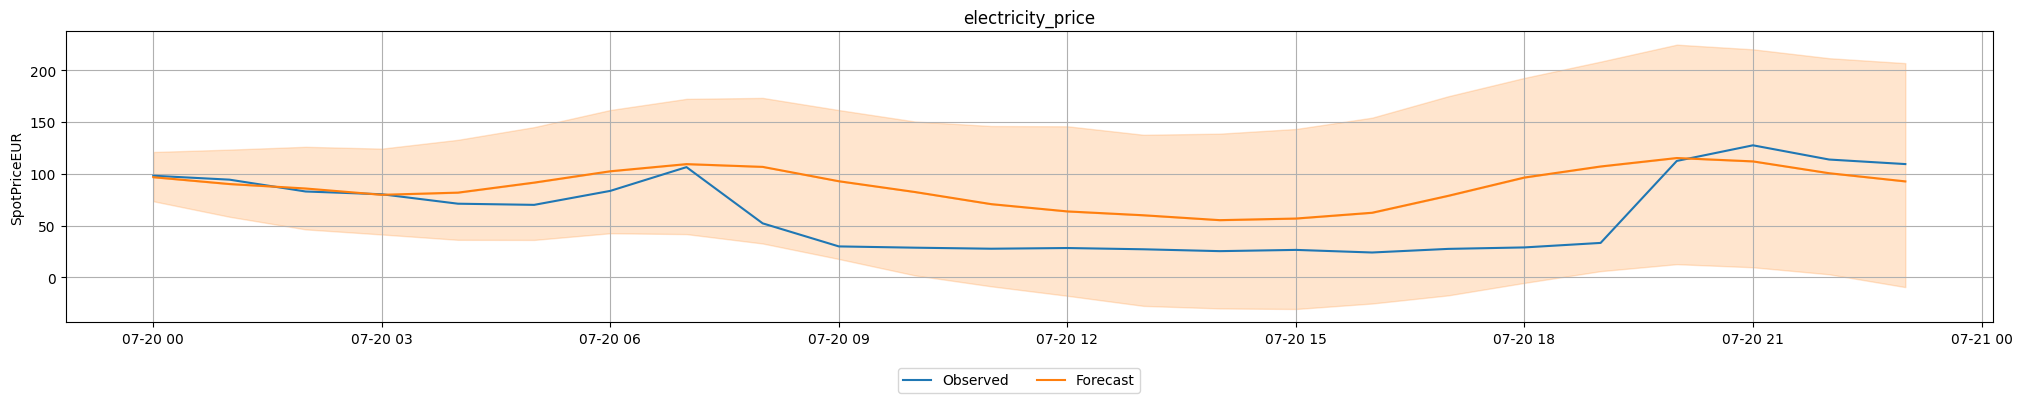

In [ ]:
import matplotlib.pyplot as plt

# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=24*5, max_num_item_ids=4)

In [35]:
# The test score is computed using the last
# prediction_length=24 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,RecursiveTabular,-0.246079,-0.787724,0.832966,0.713460,2.151551,3
1,SeasonalNaive,-0.292576,-1.523774,0.023752,1.753938,0.006180,2
2,Chronos[bolt_small],-0.302084,-0.329151,0.630876,1.249805,3.838605,7
3,DirectTabular,-0.312035,-0.713356,0.113137,0.154234,1.347648,4
4,WeightedEnsemble,-0.355467,-0.119949,24.307338,30.704530,0.536390,9
5,Naive,-0.778899,-0.689885,0.022390,2.373504,0.008918,1
6,ETS,-0.778906,-0.689924,2.924404,3.206494,0.016518,5
7,TemporalFusionTransformer,-0.823177,-0.948107,0.110065,0.024095,193.558489,8
8,Theta,-0.829049,-0.321836,19.893701,23.161266,0.007340,6
